## Notebook to evaluate tomography reconstruction schemes

### Imports/Function definitions

In [1]:
import matplotlib.pyplot as plt                 # For normal plotting
from mpl_toolkits.mplot3d import proj3d         # For 3D plotting
import numpy as np                              # For maths
from scipy import ndimage                       # For image rotations
from scipy import optimize                      # For function minimization
import astra                                    # For tomography framework
import copy                                     # For deep copying arrays

import RegTomoReconMulti as rtr                 # Modified version of Rob's CS code
import multi_axis                               # My custom functions

Compilation successful


### Full example

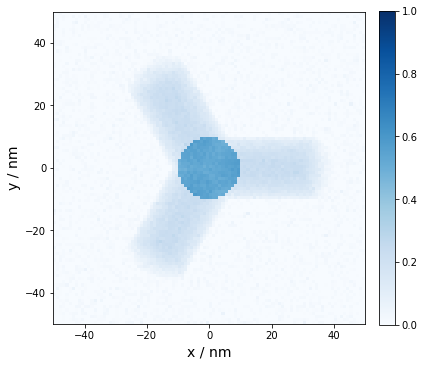

In [22]:
# Generate phantom
#X,Y,Z,P = multi_axis.generate_tri_pris()
X,Y,Z,P = multi_axis.generate_tetrapod()
#X,Y,Z,P = multi_axis.generate_pillar_cavities()
#X,Y,Z,P = multi_axis.generate_sphere()
#X,Y,Z,P = multi_axis.generate_layered_rod()

Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)


# View in 2D
multi_axis.plot_2d(X,Y,Z,Pn)

# Rotate 90 about +x and view again
#Pr = multi_axis.rotate_bulk(Pn,90,0,0)
#multi_axis.plot_2d(X,Y,Z,Pr)

In [23]:
# Generate projection data
angles = multi_axis.generate_angles()
raw_data = multi_axis.generate_proj_data(Pn,angles)
vectors = multi_axis.generate_vectors(angles)

In [5]:
# Perform reconstruction
recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm='TV1')

Started reconstruction... Finished after 10 s


In [6]:
# Match orientation of reconstruction to phantom
recon_vector = multi_axis.reorient_reconstruction(recon)

(0.33541301098491755, 0.87214535604738719)

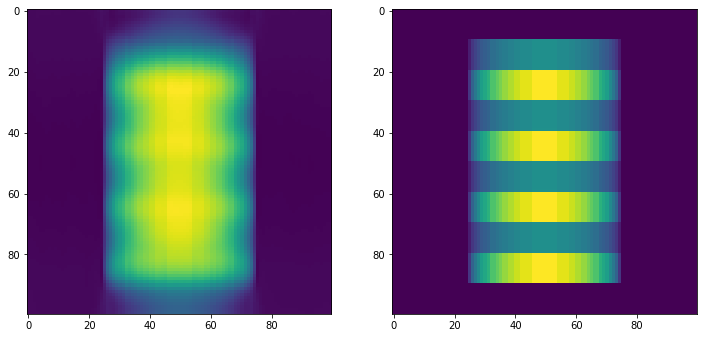

In [7]:
# Plot reconstruction
ax,ay,az = 90,0,0
a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

multi_axis.phantom_error(P,recon_vector), multi_axis.COD(P,recon_vector)

### Testing

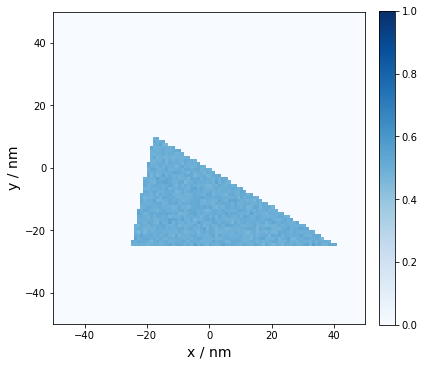

In [166]:
X,Y,Z,P = multi_axis.generate_tri_pris()
Pn = noisy(P,noise_typ='poisson',val_pois=20)
multi_axis.plot_2d(X,Y,Z,Pn)

In [167]:
# Generate different projection angle routines

# normal angles
angles = multi_axis.generate_angles(x_tilt = (-70,70,21),y_tilt = (-70,70,21))

# alternating angles
ADA_angles = []
mid = int(len(angles)/2)
for i in range(mid):
    ADA_angles.append(angles[i])
    ADA_angles.append(angles[mid+i])
    
# random angles
rand_angles = copy.deepcopy(angles)
np.random.shuffle(rand_angles)

# for i in range(len(angles)):
#     print(angles[i],'\t',ADA_angles[i],'\t',rand_angles[i])

all_angles = [angles,ADA_angles,rand_angles]

In [168]:
# Generate projection data

all_raw_data = []
all_vectors = []

for i, angs in enumerate(all_angles):
    raw_data = multi_axis.generate_proj_data(P,angs)
    vectors = multi_axis.generate_vectors(angs)
    all_raw_data.append(raw_data)
    all_vectors.append(vectors)

In [169]:
# Reconstruct

all_recons = []
for i in range(3):
    recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm='SIRT3D_CUDA')
    recon_vector = multi_axis.reorient_reconstruction(recon)
    all_recons.append(recon_vector)

0.5992456016321461

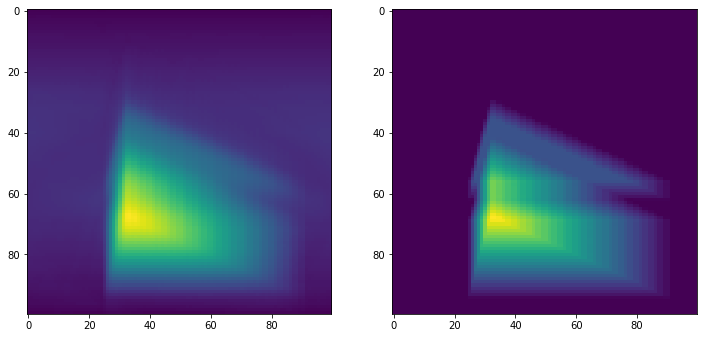

In [172]:
# Plot reconstruction
x = 2
ax,ay,az = 40,0,0
a = multi_axis.rotate_bulk(all_recons[x],ax,ay,az)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(all_recons[x],P))
e = opt.fun
e2 = e
e

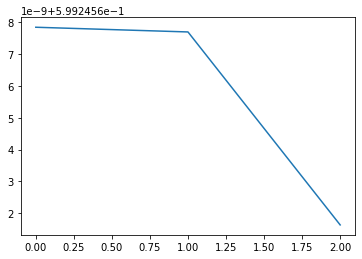

In [173]:
plt.plot([e0,e1,e2])

In [175]:
e0,e1,e2

(0.5992456078433395, 0.599245607695481, 0.5992456016321461)

### Experiments

In [55]:
# for different number of projections
# for different projections schemes
# for different ordering?
# for different reconstruction algorithms
# for different error metrics
# for different noise levels

In [56]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_tri_pris()

In [ ]:
noise_levels = [0,3,10,20,40]
num_proj = [10,20,40,100,150]
tilt_range = [30,70,90]
algs = ['SIRT3D_CUDA','BP3D_CUDA','TV1']

results = np.zeros((5,3,5,3,5,2))

for i_noise,noise in enumerate(noise_levels):
    if noise == 0:
        Pn = copy.deepcopy(P)
    else:
        Pn = noisy(P,noise_typ='poisson',val_pois=noise)
    
    for i_tilt,t in enumerate(tilt_range):
        all_angles = []
        # generate projection data
        for i_proj,num in enumerate(num_proj):
            print(noise,t,num)
            # single axis
            angles_single = multi_axis.generate_angles(x_tilt = (-t,t,num))

            # dual axis
            angles_dual = multi_axis.generate_angles(x_tilt = (-t,t,int(num/2)),y_tilt = (-t,t,int(num/2)))

            # alternating dual
            ADA_angles = []
            mid = int(num/2)
            for i in range(mid):
                ADA_angles.append(angles_dual[i])
                ADA_angles.append(angles_dual[mid+i])

            # random order dual
            rand_dual_angles = copy.deepcopy(angles)
            np.random.shuffle(rand_dual_angles)

            # random angle
            angles_rand = multi_axis.generate_angles(x_tilt=None,n_random=num)

            all_angles = [angles_single, angles_dual, ADA_angles, rand_dual_angles, angles_rand]
            all_raw_data = []
            all_vectors = []
            
            for i_alg,alg in enumerate(algs):
                for i, angs in enumerate(all_angles):
                    raw_data = multi_axis.generate_proj_data(Pn,angs)
                    vectors = multi_axis.generate_vectors(angs)
                    all_raw_data.append(raw_data)
                    all_vectors.append(vectors)

                all_recons = []
                for i in range(len(all_angles)):
                    recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm=alg)
                    recon_vector = multi_axis.reorient_reconstruction(recon)
                    all_recons.append(recon_vector)
                    
                for i_scheme,r in enumerate(all_recons):
                    cod = COD(P,r)
                    pe = phantom_error(P,r)
                    results[i_noise,i_tilt,i_proj,i_alg,i_scheme,0] = cod
                    results[i_noise,i_tilt,i_proj,i_alg,i_scheme,0] = pe

np.save('try1.npy',results)                    

0 30 10
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
0 30 20
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
0 30 40
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
0 30 100
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 3 s
0 30 150
Started reconstruction... Finished after 2 s
Started recon

In [26]:
noise_levels = [0,3,10,20,40]
algs = ['SIRT3D_CUDA','BP3D_CUDA','TV1']
t = 70
num = 71
results = np.zeros((5,3,5,2))

for i_noise,noise in enumerate(noise_levels):
    print('noise level: ', noise)
    if noise == 0:
        Pn = copy.deepcopy(P)
    else:
        Pn = noisy(P,noise_typ='poisson',val_pois=noise)

    # single axis
    angles_single = multi_axis.generate_angles(x_tilt = (-t,t,num))

    # dual axis
    angles_dual = multi_axis.generate_angles(x_tilt = (-t,t,int(num/2)),y_tilt = (-t,t,int(num/2)))

    # alternating dual
    ADA_angles = []
    mid = int(num/2)
    for i in range(mid):
        ADA_angles.append(angles_dual[i])
        ADA_angles.append(angles_dual[mid+i])

    # random order dual
    rand_dual_angles = copy.deepcopy(angles_dual)
    np.random.shuffle(rand_dual_angles)

    # random angle
    angles_rand = multi_axis.generate_angles(x_tilt=None,n_random=num)

    all_angles = [angles_single, angles_dual, ADA_angles, rand_dual_angles, angles_rand]
    all_raw_data = []
    all_vectors = []
    
    for i, angs in enumerate(all_angles):
        raw_data = multi_axis.generate_proj_data(Pn,angs)
        vectors = multi_axis.generate_vectors(angs)
        all_raw_data.append(raw_data)
        all_vectors.append(vectors)
        print('scheme: ',i)
    
    for i_alg,alg in enumerate(algs):
        all_recons = []
        for i in range(len(all_angles)):
            recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm=alg,niter=20)
            recon_vector = multi_axis.reorient_reconstruction(recon)
            all_recons.append(recon_vector)

        for i_scheme,r in enumerate(all_recons):
            cod = COD(P,r)
            pe = phantom_error(P,r)
            results[i_noise,i_alg,i_scheme,0] = cod
            results[i_noise,i_alg,i_scheme,1] = pe
            
        np.save('tripris_t70_n71_5noise_5scheme.npy',results)

0
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
3
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
10
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
20
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
40
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1

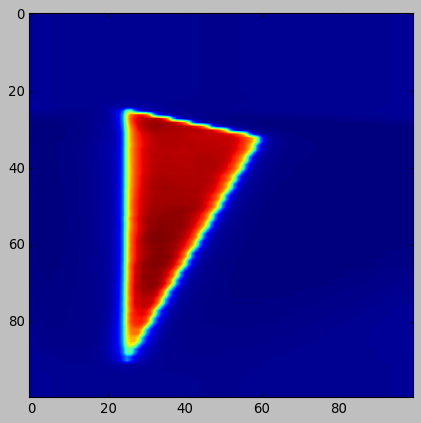

In [95]:
plt.imshow(np.mean(all_recons[0],axis=2))

(-2, 42)

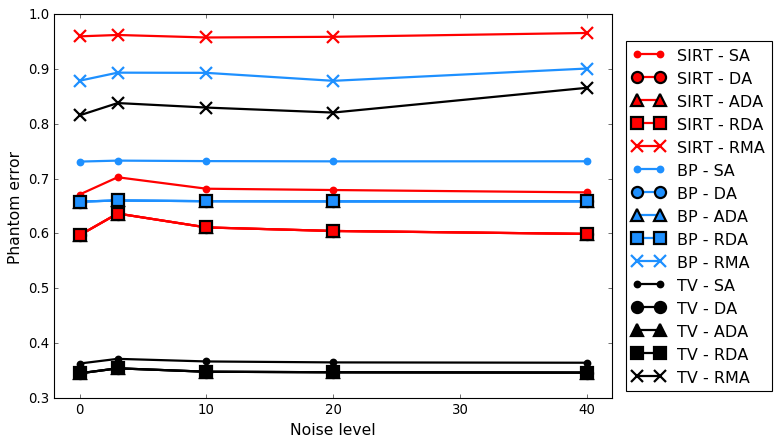

In [86]:
res_load = np.load('tripris_t70_n71_5noise_5scheme.npy')

import matplotlib as mpl
plt.style.use('classic')
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 2
fig = plt.figure(figsize=(9,6),facecolor='w')


noise_levels = [0,3,10,20,40]
algs = ['SIRT','BP','TV']
schemes = ['SA','DA','ADA','RDA','RMA']

cols = ['r','dodgerblue','k']
markers = ['.','o','^','s','x']

for i_alg,alg in enumerate(algs):
    col = cols[i_alg]
    for i_scheme,scheme in enumerate(schemes):
        marker=markers[i_scheme]
        res = res_load[:,i_alg,i_scheme,1]
        label = alg+ ' - ' + scheme
        plt.plot(noise_levels,res,label=label,color=col,marker=marker)

plt.xlabel('Noise level',fontsize=14)
plt.ylabel('Phantom error',fontsize=14)
plt.legend(bbox_to_anchor=(1.3,.95))
plt.xlim([-2,42])

In [156]:
# try again

X,Y,Z,P = multi_axis.generate_tri_pris()
t = 70
num = 35
noise_levels = [0.1,1,10,100]
results = []
for n in noise_levels:
    Pn = noisy(P,noise_typ='poisson',val_pois=n)
    
    angles_x = multi_axis.generate_angles(x_tilt = (-t,t,num))
    angles_y = multi_axis.generate_angles(x_tilt = None,y_tilt = (-t,t,num))
    
    angs = angles_x
    raw_data_x = multi_axis.generate_proj_data(Pn,angs)
    vectors = multi_axis.generate_vectors(angs)
    recon = multi_axis.generate_reconstruction(raw_data_x,vectors,algorithm='TV1',niter=20)
    recon_x = multi_axis.reorient_reconstruction(recon)

    angs = angles_y
    raw_data_y = multi_axis.generate_proj_data(Pn,angs)
    vectors = multi_axis.generate_vectors(angs)
    recon = multi_axis.generate_reconstruction(raw_data_y,vectors,algorithm='TV1',niter=20)
    recon_y = multi_axis.reorient_reconstruction(recon)
    
    recon_xy = np.mean([recon_x,recon_y],axis=0)

    raw_data_dual = np.concatenate((raw_data_x,raw_data_y),axis=1)
    angs = np.concatenate((angles_x,angles_y))
    vectors = multi_axis.generate_vectors(angs)
    recon = multi_axis.generate_reconstruction(raw_data_dual,vectors,algorithm='TV1',niter=20)
    recon_dual = multi_axis.reorient_reconstruction(recon)
    
    cods = COD(P,recon_x),COD(P,recon_y),COD(P,recon_xy),COD(P,recon_dual)
    pes = phantom_error(P,recon_x),phantom_error(P,recon_y),phantom_error(P,recon_xy),phantom_error(P,recon_dual)
    results.append([cods,pes])
    np.save('Parameter tests/4dual_4noises.npy', results)

Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s


In [138]:
np.shape(res_load)

(4, 2, 4)

(0.08, 120)

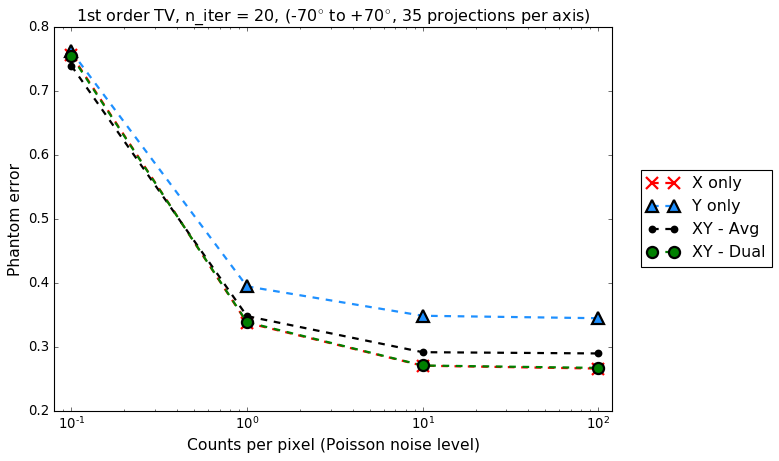

In [165]:
res_load = np.load('Parameter tests/4dual_4noises.npy')

import matplotlib as mpl
plt.style.use('classic')
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 2
fig = plt.figure(figsize=(9,6),facecolor='w')


noise_levels = [0.1,1,10,100]
schemes = ['X only','Y only','XY - Avg', 'XY - Dual']

cols = ['r','dodgerblue','k','g']
markers = ['x','^','.','o']

for i_scheme,scheme in enumerate(schemes):
    col=cols[i_scheme]
    res = res_load[:,1,i_scheme]
    label = scheme
    marker = markers[i_scheme]
    plt.plot(noise_levels,res,'--o',label=label,color=col,alpha=1,marker=marker)

plt.xlabel('Counts per pixel (Poisson noise level)',fontsize=14)
plt.xscale('log')
plt.ylabel('Phantom error',fontsize=14)
plt.legend(bbox_to_anchor=(1.3,.65))
plt.title('1st order TV, n_iter = 20, (-70$^{\circ}$ to +70$^{\circ}$, 35 projections per axis)')
plt.xlim([.08,120])

## Tilt experiments

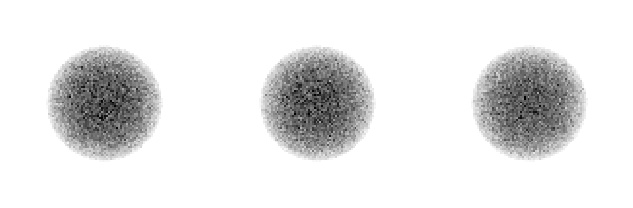

In [3]:
# Plot each phantom

#X,Y,Z,P = multi_axis.generate_tri_pris()
#X,Y,Z,P = multi_axis.generate_tetrapod()
#X,Y,Z,P = multi_axis.generate_pillar_cavities()
X,Y,Z,P = multi_axis.generate_sphere()
#X,Y,Z,P = multi_axis.generate_layered_rod()
Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=1)

fig= plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax2.imshow(np.flipud(np.mean(Pn,axis=2).T),cmap='Greys')
ax1.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(Pn,90,0,0),axis=2).T),cmap='Greys')
ax3.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(Pn,0,90,0),axis=2).T),cmap='Greys')

ax1.axis('off'),ax2.axis('off'),ax3.axis('off')
plt.tight_layout()

Text(0.5, 0, 'z')

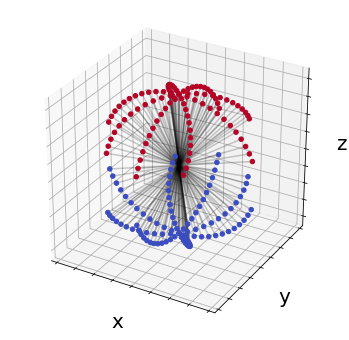

In [2]:
# plot collection schemes
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')


angles = multi_axis.generate_angles(mode='quad',x_tilt=(-70,70,25),y_tilt=(-70,70,25),rand=(70,70,50))

for i,a in enumerate(angles):
    mrot = multi_axis.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1])
    plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
    ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=20,cmap='coolwarm',alpha=1)
    #ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=i,s=20,cmap='coolwarm',alpha=1)

ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_zticklabels([])
plt.xlabel('x',fontsize='20')
plt.ylabel('y',fontsize='20')
ax1.set_zlabel('z',fontsize='20')

In [25]:
algs = ['BP3D_CUDA','SIRT3D_CUDA','TV1']

X,Y,Z,P = multi_axis.generate_tetrapod()

Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)

# Generate projection data
angles = multi_axis.generate_angles()
raw_data = multi_axis.generate_proj_data(Pn,angles)
vectors = multi_axis.generate_vectors(angles)

#recon
recons = []
for alg in algs:
    recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm=alg)
    recon_vector = multi_axis.reorient_reconstruction(recon)
    recons.append(recon_vector)

Started reconstruction... Finished after 1 s


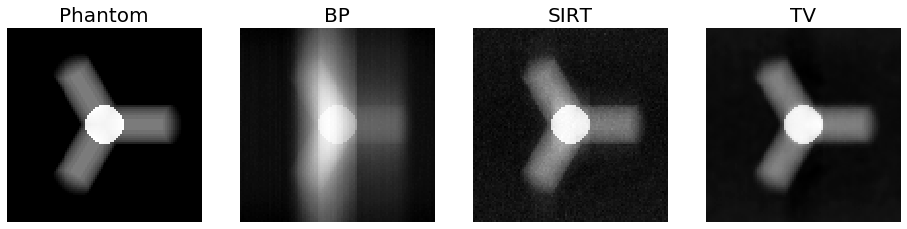

In [34]:
fig= plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
c='Greys_r'
ax1.imshow(np.flipud(np.mean(P,axis=2).T),cmap=c)
ax2.imshow(np.flipud(np.mean(recons[0],axis=2).T),cmap=c)
ax3.imshow(np.flipud(np.mean(recons[1],axis=2).T),cmap=c)
ax4.imshow(np.flipud(np.mean(recons[2],axis=2).T),cmap=c)

ax1.set_title('Phantom',fontsize=20)
ax2.set_title('BP',fontsize=20)
ax3.set_title('SIRT',fontsize=20)
ax4.set_title('TV',fontsize=20)

for ax in [ax1,ax2,ax3,ax4]:
    ax.axis('off')